In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import matplotlib.pyplot as plt

from fuel.datasets.hdf5 import H5PYDataset

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import mnist

from made import MaskingDense

Using TensorFlow backend.


## Variational Autoencoder Parameters

In [2]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)

batch_size = 100
latent_dim = 128
intermediate_dim = 512
epsilon_std = 1.0
epochs = 1000
activation = 'elu'
dropout = 0.0
decay = 0.0
learning_rate = 0.001
num_iaf = 4

## Load CIFAR10 dataset

In [3]:
ftrain = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('train',))
X_train, y_train = ftrain.get_data(ftrain.open(), slice(0, ftrain.num_examples))
X_train = np.moveaxis(X_train[:], 1, 3)
X_train = X_train / 255.

ftest = H5PYDataset("../../data/cifar10/cifar10.hdf5", which_sets=('test',))
X_test, y_test = ftest.get_data(ftest.open(), slice(0, ftest.num_examples))
X_test = np.moveaxis(X_test[:], 1, 3)
X_test = X_test / 255.

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


# Helper Functions

In [4]:
def create_dense_layers(stage, width, activation=activation, dropout=True):
    dense_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        Activation(activation),
    ]
    if dropout:
        layers.append(Dropout(dropout))
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def epsilon(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    return K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)

def combine_z_0(args, batch_size=batch_size, latent_dim=latent_dim, epsilon_std=epsilon_std):
    eps, z_mean, z_log_sigma = args
    return z_mean + K.exp(z_log_sigma) * eps

def combine_arnn(args):
    z_t, mean, sigma = args
    return z_t * sigma + mean * (1. - sigma)

def make_iaf_layer(prev_z, enc_h, reverse=False):
    if reverse:
        prev_z = Lambda(lambda x: K.reverse(x, axes=-1))(prev_z)
        
    iaf_in = [prev_z, enc_h] if enc_h is not None else prev_z
    m = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    s = MaskingDense(masking_dim, latent_dim, dropout_rate=0., hidden_layers=2,
                     kernel_regularizer=l2(0.001),
                     bias_regularizer=l2(0.001),
                     activation='sigmoid', out_activation=None)(iaf_in)
    sigma = Activation('sigmoid')(s)
    
    return Lambda(combine_arnn)([prev_z, m, sigma]), sigma

In [5]:
def create_enc_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['enc_conv', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Conv2D(name=conv_name, **kwargs),
        Activation(activation),
    ]
    return layers

def create_dense_layers(stage, width):
    dense_name = '_'.join(['enc_dense', str(stage)])
    bn_name = '_'.join(['enc_bn', str(stage)])
    layers = [
        Dense(width, name=dense_name),
        BatchNormalization(name=bn_name),
        Activation(activation),
        Dropout(dropout),
    ]
    return layers

def inst_layers(layers, in_layer):
    x = in_layer
    for layer in layers:
        if isinstance(layer, list):
            x = inst_layers(layer, x)
        else:
            x = layer(x)
        
    return x

def create_dec_trans_conv_layers(stage, **kwargs):
    conv_name = '_'.join(['dec_trans_conv', str(stage)])
    bn_name = '_'.join(['dec_bn', str(stage)])
    layers = [
        Conv2DTranspose(name=conv_name, **kwargs),
        BatchNormalization(name=bn_name),
        Activation(activation),
    ]
    return layers

## Loss Function

In [6]:
def logpz(x, x_decoded_mean):
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)

def logqz_x(x, x_decoded_mean):
    det = _z_log_sigma_0
    for z_sigma in _z_sigmas:
        det += K.log(z_sigma)
    
    return -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)

def logpx_z(x, x_decoded_mean):
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * img_chns * metrics.binary_crossentropy(x, x_decoded_mean)
    return -xent_loss

def vae_loss(x, x_decoded_mean):
    # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x)
    return K.mean(-logpx_z(x, x_decoded_mean) - logpz(x, x_decoded_mean) + logqz_x(x, x_decoded_mean), axis=-1)

# Basic VAE

In [7]:
# Encoder
enc_filters=128
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters // 4, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
    create_dense_layers(stage=5, width=intermediate_dim),
]
x_input = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x_input)

# Original z_0
e_0 = Lambda(epsilon)(_enc_dense)
_z_sigmas = []
_z_mean_0 = Dense(latent_dim)(_enc_dense)
_z_log_sigma_0 = Dense(latent_dim)(_enc_dense)
z_0 = Lambda(combine_z_0)([e_0, _z_mean_0, _z_log_sigma_0])
z = z_0

# Decoder
dec_filters = 128
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    create_dense_layers(stage=11, width=intermediate_dim),
    Reshape((4, 4, intermediate_dim // 16)),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(14, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(15, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=3, kernel_size=1, strides=1, activation='sigmoid'),
]
_dec_dense = inst_layers(decoder_layers, z)
_output = _dec_dense

In [8]:
vae = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 32, 32, 3)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (100, 32, 32, 128)    3584        input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (100, 32, 32, 128)    0           enc_conv_1[0][0]                 
____________________________________________________________________________________________________
enc_conv_2 (Conv2D)              (100, 16, 16, 64)     73792       activation_1[0][0]               
___________________________________________________________________________________________

In [9]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=50)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=0.001 * learning_rate)
callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  6903.516147375107


,loss,lr,val_loss
count,277.000000,277.000000,277.000000
mean,1821.097390,0.000763,1824.622515
std,9.040527,0.000323,8.294499
min,1815.291963,0.000125,1820.176823
0%,1815.291963,0.000125,1820.176823
25%,1816.719384,0.000500,1820.729359
50%,1819.159084,0.001000,1822.089125
75%,1822.242155,0.001000,1823.844983
95%,1832.382899,0.001000,1841.930554
99%,1850.352631,0.001000,1858.444650


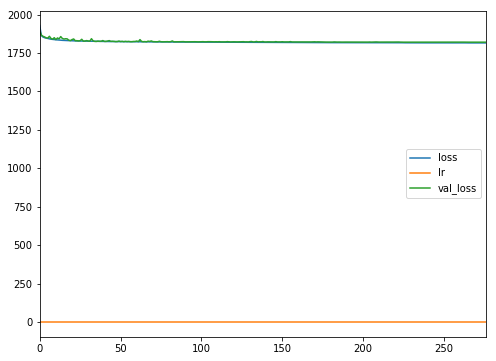

In [10]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [11]:
# Eval logpx loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpx_z)
val_logpx = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logpz loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpz)
val_logpz = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logqz_x loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logqz_x)
val_logqz_x = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print()
print("log(p(x|z)) = %.2f" % val_logpx)
print("log(p(z)) = %.2f" % val_logpz)
print("log(q(z|x)) = %.2f" % val_logqz_x)

 9900/10000 [============================>.] - ETA: 0s
log(p(x|z)) = 1781.58
log(p(z)) = 181.44
log(q(z|x)) = 143.01


In [12]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

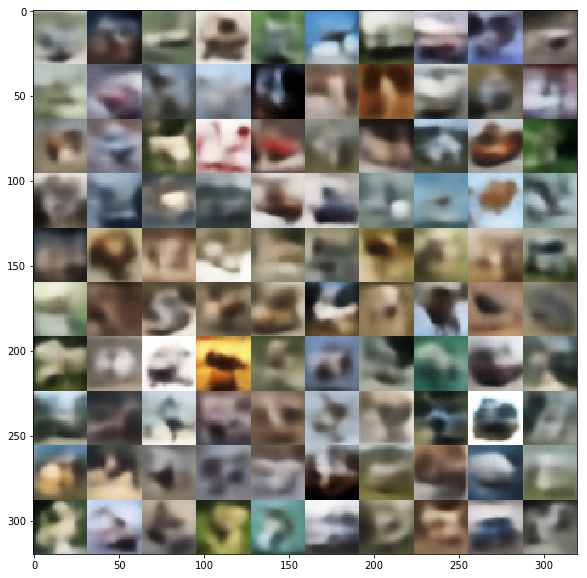

In [13]:
import matplotlib.pyplot as plt
n = 10
figure = np.zeros((img_rows * n, img_cols * n, img_chns))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(img_rows, img_cols, img_chns)
        
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# IAF VAE

In [14]:
# Encoder
enc_filters=128
enc_layers = [
    create_enc_conv_layers(stage=1, filters=enc_filters, kernel_size=3, strides=1, padding='same'),
    create_enc_conv_layers(stage=2, filters=enc_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_enc_conv_layers(stage=3, filters=enc_filters // 4, kernel_size=3, strides=2, padding='same'),
    Flatten(),
    create_dense_layers(stage=4, width=intermediate_dim),
    create_dense_layers(stage=5, width=intermediate_dim),
]
x_input = Input(batch_shape=(batch_size,) + original_img_size)
_enc_dense = inst_layers(enc_layers, x_input)

# Original z_0
e_0 = Lambda(epsilon)(_enc_dense)
_z_sigmas = []
_z_mean_0 = Dense(latent_dim)(_enc_dense)
_z_log_sigma_0 = Dense(latent_dim)(_enc_dense)
z_0 = Lambda(combine_z_0)([e_0, _z_mean_0, _z_log_sigma_0])

# IAF flows
masking_dim = 10 * latent_dim
h = Dense(latent_dim, activation='sigmoid')(_enc_dense)
z_t = z_0
for i in range(num_iaf):
    reverse = (i > 0)
    z_t, _z_sigma_t = make_iaf_layer(z_t, h, reverse=reverse)
    _z_sigmas.append(_z_sigma_t)
z = z_t

# Decoder
dec_filters = 128
decoder_layers = [
    create_dense_layers(stage=10, width=intermediate_dim),
    create_dense_layers(stage=11, width=intermediate_dim),
    Reshape((4, 4, intermediate_dim // 16)),
    create_dec_trans_conv_layers(12, filters=dec_filters, kernel_size=3, strides=1, padding='same'),
    create_dec_trans_conv_layers(13, filters=dec_filters // 2, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(14, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    create_dec_trans_conv_layers(15, filters=dec_filters // 4, kernel_size=3, strides=2, padding='same'),
    Conv2DTranspose(name='x_decoded', filters=3, kernel_size=1, strides=1, activation='sigmoid'),
]
_dec_dense = inst_layers(decoder_layers, z)
_output = _dec_dense

In [15]:
vae = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
vae.compile(optimizer=optimizer, loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (100, 32, 32, 3)      0                                            
____________________________________________________________________________________________________
enc_conv_1 (Conv2D)              (100, 32, 32, 128)    3584        input_3[0][0]                    
____________________________________________________________________________________________________
activation_12 (Activation)       (100, 32, 32, 128)    0           enc_conv_1[0][0]                 
____________________________________________________________________________________________________
enc_conv_2 (Conv2D)              (100, 16, 16, 64)     73792       activation_12[0][0]              
___________________________________________________________________________________________

In [16]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=50 + 10 * num_iaf)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=40, min_lr=0.001 * learning_rate)

callbacks=[early_stopping, reduce_lr]
if 'CMDLINE' not in os.environ:
    callbacks += [TQDMNotebookCallback()]

history = vae.fit(
    X_train, X_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, X_test),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Elapsed:  17552.44598031044


,loss,lr,val_loss
count,430.000000,430.000000,430.000000
mean,1821.271437,0.000749,1826.305403
std,8.508874,0.000353,6.974897
min,1815.074288,0.000063,1823.051597
0%,1815.074288,0.000063,1823.051597
25%,1816.678655,0.000500,1823.478399
50%,1819.609931,0.001000,1824.511641
75%,1822.945424,0.001000,1825.766205
95%,1832.846421,0.001000,1836.518597
99%,1848.882801,0.001000,1863.733976


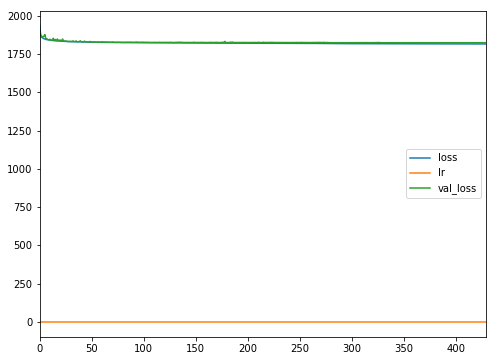

In [17]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [18]:
# Eval logpx loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpx_z)
val_logpx = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logpz loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logpz)
val_logpz = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

# Eval logqz_x loss
m = Model(inputs=x_input, outputs=_output)
optimizer = Adam(lr=learning_rate, decay=decay)
m.compile(optimizer=optimizer, loss=logqz_x)
val_logqz_x = -m.evaluate(x=X_test, y=X_test, batch_size=batch_size)

print()
print("log(p(x|z)) = %.2f" % val_logpx)
print("log(p(z)) = %.2f" % val_logpz)
print("log(q(z|x)) = %.2f" % val_logqz_x)

10000/10000 [==============================] - 2s     

log(p(x|z)) = 1786.24
log(p(z)) = 181.48
log(q(z|x)) = 144.69


In [19]:
g_z = Input(shape=(latent_dim,))
g_output = inst_layers(decoder_layers, g_z)
generator = Model(g_z, g_output)

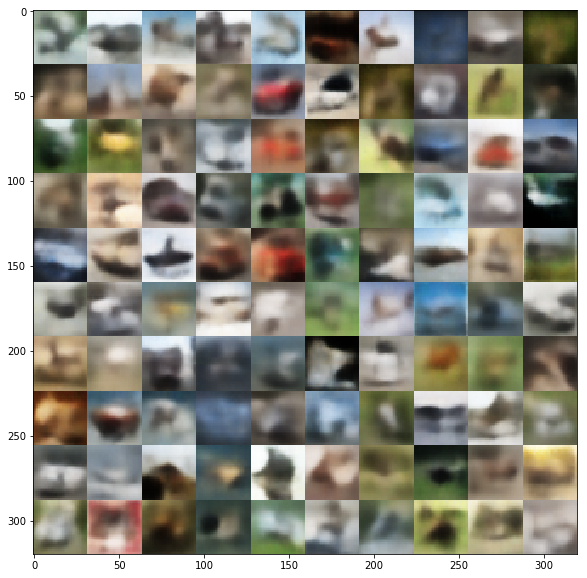

In [20]:
import matplotlib.pyplot as plt
n = 10
figure = np.zeros((img_rows * n, img_cols * n, img_chns))

for j in range(n):
    for i in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        x_decoded = generator.predict(z_sample, batch_size=1)
        digit = x_decoded.reshape(img_rows, img_cols, img_chns)
        
        d_x = i * img_rows
        d_y = j * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols] = digit
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()